In [1]:
import numpy as np
from math import ceil
from typing import List, Tuple
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
from tssparse import get_tsvalues, get_input_t
from torchmodels import LSTMTSSparseToTTE

In [4]:
# generate some arrival times with fixed intervals
max_t = 10
num_evtypes = 3
iats_d = {k: k+1 for k in range(num_evtypes)}

In [5]:
# actual data should look something like this
arrivaltimes = [
    [list(range(d, max_t, v)) for k, v in iats_d.items()]
    for d in range(5)
    for _ in range(10)
]

In [6]:
# arrival times for 0-th replicate
arrivaltimes[0]

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [0, 2, 4, 6, 8], [0, 3, 6, 9]]

find normalization to estimate time-to-event

In [7]:
mean_arrival_times = [[np.mean(np.diff(arrtype)) for arrtype in arrobs] for arrobs in arrivaltimes]
event_type_normalization = list(np.mean(np.array(mean_arrival_times), axis=0))

In [8]:
event_type_normalization

[1.0, 2.0, 3.0]

In [9]:
model = LSTMTSSparseToTTE(num_evtypes, max_t)
optimizer = optim.SGD(model.parameters(), lr=1)

In [10]:
def get_target(arrivaltimes, max_t):
    return torch.cat([
        torch.Tensor(
            get_input_t(t, arrivaltimes, training=False)
        )[
            ..., [1] # tse
        ].view(1, len(arrivaltimes), -1) 
        for t in range(max_t)
    ])

In [11]:
def get_loss(true, pred):
    batch_size = true.shape[1]
    norm = torch.Tensor(event_type_normalization).repeat(max_t, batch_size, 1)
    return nn.MSELoss()(true/norm, F.relu(pred)/norm)

In [12]:
for epoch in range(100):
    model.zero_grad()
    batch_size = len(arrivaltimes)
    
    loss = get_loss(model(arrivaltimes), get_target(arrivaltimes, max_t))
    loss.backward()
    optimizer.step()
    with torch.no_grad():
        print ('epoch: {} loss: {}'.format(
            epoch, 
            get_loss(model(arrivaltimes), get_target(arrivaltimes, max_t)).item()
        ))

epoch: 0 loss: 0.4027062654495239
epoch: 1 loss: 0.39021825790405273
epoch: 2 loss: 0.3957674205303192
epoch: 3 loss: 0.39257141947746277
epoch: 4 loss: 0.3913699686527252
epoch: 5 loss: 0.3811717629432678
epoch: 6 loss: 0.39564916491508484
epoch: 7 loss: 0.36809736490249634
epoch: 8 loss: 0.37844961881637573
epoch: 9 loss: 0.3746276795864105
epoch: 10 loss: 0.3782176077365875
epoch: 11 loss: 0.3721534311771393
epoch: 12 loss: 0.3716525733470917
epoch: 13 loss: 0.3597373962402344
epoch: 14 loss: 0.3573892414569855
epoch: 15 loss: 0.35926172137260437
epoch: 16 loss: 0.3576687276363373
epoch: 17 loss: 0.3465019166469574
epoch: 18 loss: 0.359171986579895
epoch: 19 loss: 0.3679785132408142
epoch: 20 loss: 0.3407660126686096
epoch: 21 loss: 0.34228619933128357
epoch: 22 loss: 0.34844303131103516
epoch: 23 loss: 0.34651488065719604
epoch: 24 loss: 0.3497084081172943
epoch: 25 loss: 0.3403307795524597
epoch: 26 loss: 0.32818180322647095
epoch: 27 loss: 0.3328571915626526
epoch: 28 loss: 0.331

In [13]:
import matplotlib.pyplot as plt

In [14]:
with torch.no_grad():
    pred = model(arrivaltimes).numpy()

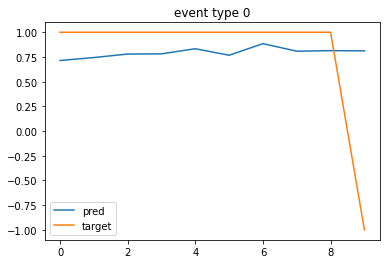

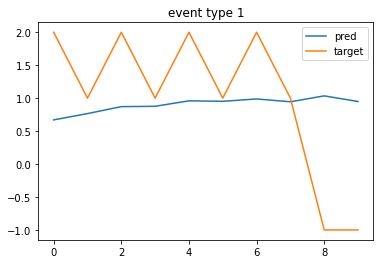

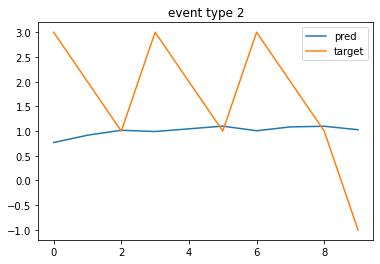

In [15]:
for i in range(num_evtypes):
    plt.plot(pred[:, 0, i], label='pred')
    plt.plot(get_target(arrivaltimes, max_t).numpy()[:, 0, i], label='target')
    plt.title('event type {}'.format(i))
    plt.legend()
    plt.show()